# 06 — Hybrid Recommender Model

This notebook combines the best Collaborative Filtering model **(SGD-MF)** with the **Content-Based** model into an adaptive hybrid recommender. **No retraining** — we load saved models and blend their scores.

## Blending strategy

$$\hat{r}(u, m) = \alpha(u) \cdot \hat{r}_{\text{CF}}(u, m) \;+\; (1 - \alpha(u)) \cdot \hat{r}_{\text{CB}}(u, m)$$

| User type   | Training ratings | CF weight α | CB weight 1−α |
|-------------|-----------------|-------------|---------------|
| New user    | < 50            | 0.3         | 0.7           |
| Moderate    | 50 – 200        | 0.6         | 0.4           |
| Power user  | > 200           | 0.8         | 0.2           |

## Notebook outline
1. Load saved SGD-MF and CB models
2. Calibrate CB similarity scores → rating scale (linear regression)
3. Define adaptive blending functions
4. Evaluate hybrid on a held-out test sample
5. Compare all models in one table
6. Generate top-N recommendations for sample users
7. Save final results

In [32]:
import pickle
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-v0_8-whitegrid')
print('Libraries loaded.')

Libraries loaded.


In [33]:
# ── Config & paths ────────────────────────────────────────────────────────
project_root = Path.cwd().parent
config_path  = project_root / 'config' / 'config.yaml'

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

processed_dir = project_root / config['data']['processed_dir']
models_dir    = project_root / config['models']['save_dir']
hybrid_cfg    = config['models']['hybrid']
eval_config   = config['evaluation']

print(f'Project root : {project_root}')
print(f'Models dir   : {models_dir}')
print(f'\nHybrid config:')
for k, v in hybrid_cfg.items():
    print(f'  {k}: {v}')

Project root : c:\Users\ololi\StudioProjects\movie-recommender\src
Models dir   : c:\Users\ololi\StudioProjects\movie-recommender\src\models

Hybrid config:
  new_user_threshold: 50
  moderate_user_threshold: 200
  new_user_cf_weight: 0.3
  moderate_user_cf_weight: 0.6
  established_user_cf_weight: 0.8


In [34]:
# ── SGDMatrixFactorization must be defined before pickle.load ─────────────
# Pickle needs the class to exist in order to reconstruct the saved object.

class SGDMatrixFactorization:
    """Matrix Factorization using Stochastic Gradient Descent (matches notebook 04)."""

    def __init__(self, n_users, n_items, n_factors=100, lr=0.005, reg=0.02,
                 n_epochs=20, random_state=42):
        self.n_factors = n_factors
        self.lr = lr
        self.reg = reg
        self.n_epochs = n_epochs
        rng = np.random.RandomState(random_state)
        self.user_factors = rng.normal(0, 0.1, (n_users, n_factors))
        self.item_factors = rng.normal(0, 0.1, (n_items, n_factors))
        self.user_biases = np.zeros(n_users)
        self.item_biases = np.zeros(n_items)
        self.global_mean = 0

    def fit(self, train_df):
        self.global_mean = train_df['rating'].mean()
        users   = train_df['user_idx'].values
        items   = train_df['movie_idx'].values
        ratings = train_df['rating'].values
        for epoch in range(self.n_epochs):
            indices = np.random.permutation(len(ratings))
            total_loss = 0
            for idx in indices:
                u, i, r = users[idx], items[idx], ratings[idx]
                pred = (self.global_mean + self.user_biases[u] +
                        self.item_biases[i] + self.user_factors[u] @ self.item_factors[i])
                err  = r - pred
                total_loss += err ** 2
                self.user_biases[u] += self.lr * (err - self.reg * self.user_biases[u])
                self.item_biases[i] += self.lr * (err - self.reg * self.item_biases[i])
                user_f = self.user_factors[u].copy()
                self.user_factors[u] += self.lr * (err * self.item_factors[i] - self.reg * self.user_factors[u])
                self.item_factors[i] += self.lr * (err * user_f               - self.reg * self.item_factors[i])
            print(f"    Epoch {epoch+1}/{self.n_epochs} - Train RMSE: {np.sqrt(total_loss/len(ratings)):.4f}")

    def predict(self, user_idx, item_idx):
        pred = (self.global_mean + self.user_biases[user_idx] +
                self.item_biases[item_idx] +
                self.user_factors[user_idx] @ self.item_factors[item_idx])
        return float(np.clip(pred, 0.5, 5.0))

    def predict_batch(self, user_indices, item_indices):
        preds = (self.global_mean +
                 self.user_biases[user_indices] +
                 self.item_biases[item_indices] +
                 np.sum(self.user_factors[user_indices] * self.item_factors[item_indices], axis=1))
        return np.clip(preds, 0.5, 5.0)


# ── Load CF models ────────────────────────────────────────────────────────
with open(models_dir / 'sgd_mf_model.pkl', 'rb') as f:
    sgd_model = pickle.load(f)

with open(models_dir / 'svd_components.pkl', 'rb') as f:
    svd_data = pickle.load(f)

cf_results = pd.read_csv(models_dir / 'cf_evaluation_results.csv', index_col=0)

print('CF models loaded.')
print(f'SGD-MF: {sgd_model.user_factors.shape[0]:,} users  x  '
      f'{sgd_model.item_factors.shape[0]:,} movies  x  {sgd_model.n_factors} factors')
print(f'Global mean rating: {sgd_model.global_mean:.4f}')
print(f'\nPrevious CF results:')
print(cf_results[['rmse', 'mae']].round(4).to_string())

CF models loaded.
SGD-MF: 162,112 users  x  32,424 movies  x  100 factors
Global mean rating: 3.5273

Previous CF results:
                        rmse     mae
model                               
Baseline (Mean+Bias)  1.0060  0.7672
SVD                   1.0042  0.7654
SGD-MF                1.0019  0.7678
KNN Item-Based        1.0628  0.8240
KNN User-Based        1.0700  0.8316


In [35]:
# ── Load CB model ─────────────────────────────────────────────────────────
with open(models_dir / 'cb_model.pkl', 'rb') as f:
    cb_model_data = pickle.load(f)

movie_feature_matrix = cb_model_data['movie_feature_matrix']  # sparse (n_movies, n_features)
movie_idx_lookup     = cb_model_data['movie_idx_lookup']       # movieId -> row index
idx_to_movie_id      = cb_model_data['idx_to_movie_id']        # row index -> movieId
RATING_MIDPOINT      = cb_model_data['rating_midpoint']

# CB evaluation metrics saved by notebook 05
try:
    cb_eval = cb_model_data['evaluation']
    cb_rmse_scaled = float(cb_eval.get('rmse_scaled', 1.1027)) if isinstance(cb_eval, dict) else 1.1027
    cb_mae_scaled  = float(cb_eval.get('mae_scaled',  0.8604)) if isinstance(cb_eval, dict) else 0.8604
except Exception:
    cb_rmse_scaled, cb_mae_scaled = 1.1027, 0.8604

print('CB model loaded.')
print(f'Feature matrix : {movie_feature_matrix.shape}  sparse, {movie_feature_matrix.nnz:,} non-zeros')
print(f'Movies indexed : {len(movie_idx_lookup):,}')
print(f'Rating midpoint: {RATING_MIDPOINT}')
print(f'\nCB evaluation (from notebook 05):')
print(f'  RMSE (scaled): {cb_rmse_scaled:.4f}')
print(f'  MAE  (scaled): {cb_mae_scaled:.4f}')

CB model loaded.
Feature matrix : (32424, 1021)  sparse, 458,005 non-zeros
Movies indexed : 32,424
Rating midpoint: 3.0

CB evaluation (from notebook 05):
  RMSE (scaled): 1.1027
  MAE  (scaled): 0.8604


In [36]:
# ── Load data & temporal split (identical to notebook 04) ─────────────────
print('Loading data...')
ratings = pd.read_parquet(processed_dir / 'ratings_cleaned.parquet')
movies  = pd.read_parquet(processed_dir / 'movies_cleaned.parquet')

ratings_sorted = ratings.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(ratings_sorted) * (1 - eval_config['test_size']))
train_df  = ratings_sorted.iloc[:split_idx].copy()
test_df   = ratings_sorted.iloc[split_idx:].copy()

print(f'Total ratings : {len(ratings):,}')
print(f'Train         : {len(train_df):,}  ({100*(1-eval_config["test_size"]):.0f}%)')
print(f'Test          : {len(test_df):,}   ({100*eval_config["test_size"]:.0f}%)')
print(f'Train users   : {train_df["userId"].nunique():,}')
print(f'Train movies  : {train_df["movieId"].nunique():,}')

Loading data...
Total ratings : 24,914,810
Train         : 19,931,848  (80%)
Test          : 4,982,962   (20%)
Train users   : 137,439
Train movies  : 26,060


In [37]:
# ── Reconstruct CF index maps from the FULL dataset ───────────────────────
# Notebook 04 built user/movie maps from all ratings (not just train),
# so every user/movie gets an index even if they only appear in test.
unique_users  = sorted(ratings['userId'].unique())
unique_movies = sorted(ratings['movieId'].unique())

user_id_map  = {uid: idx for idx, uid in enumerate(unique_users)}
movie_id_map = {mid: idx for idx, mid in enumerate(unique_movies)}

# Verify dimensions match the loaded model
assert len(unique_users)  == sgd_model.user_factors.shape[0], \
    f'User mismatch: {len(unique_users)} vs {sgd_model.user_factors.shape[0]}'
assert len(unique_movies) == sgd_model.item_factors.shape[0], \
    f'Movie mismatch: {len(unique_movies)} vs {sgd_model.item_factors.shape[0]}'

global_mean = sgd_model.global_mean

# Pre-compute arrays for vectorised scoring
all_movie_ids  = np.array(unique_movies, dtype=np.int64)
all_cf_midxs   = np.arange(len(unique_movies), dtype=np.int64)
all_cb_midxs   = np.array([movie_idx_lookup.get(m, -1) for m in unique_movies], dtype=np.int64)
has_cb_feature = all_cb_midxs >= 0

# Pre-compute training rating counts per user (for adaptive alpha)
user_train_counts = train_df.groupby('userId').size().to_dict()

print('Index maps verified ✓')
print(f'  Total users  (full dataset) : {len(user_id_map):,}')
print(f'  Total movies (full dataset) : {len(movie_id_map):,}')
print(f'  Movies with CB features     : {has_cb_feature.sum():,}')

Index maps verified ✓
  Total users  (full dataset) : 162,112
  Total movies (full dataset) : 32,424
  Movies with CB features     : 32,424


## Adaptive Hybrid Strategy

**Why adaptive?**

- **Collaborative Filtering** learns from the *collective wisdom* of all users. It needs a rich rating history for each user to work well. It cannot make predictions for users or movies it has never seen (cold-start problem).
- **Content-Based Filtering** uses *movie features* (genres, tags, year). It only needs the user to have rated a handful of movies to build a preference profile, and it can recommend any movie that has features — even brand-new ones.

By weighting CF more heavily for users who have rated many movies, and CB more heavily for new users, we get the best of both worlds.

**CB calibration** — the CB model outputs raw cosine similarity scores, which are on a different scale than ratings. Before blending we fit a simple linear regression:

$$\hat{r}_{\text{CB}} = a \times \text{sim}(u, m) + b$$

In [38]:
# ── Adaptive alpha function ───────────────────────────────────────────────
new_thresh  = hybrid_cfg['new_user_threshold']       # 50
mod_thresh  = hybrid_cfg['moderate_user_threshold']  # 200
alpha_new   = hybrid_cfg['new_user_cf_weight']       # 0.3
alpha_mod   = hybrid_cfg['moderate_user_cf_weight']  # 0.6
alpha_power = hybrid_cfg['established_user_cf_weight'] # 0.8


def get_alpha(user_id):
    """Return CF weight alpha based on the user's training history size."""
    n = user_train_counts.get(user_id, 0)
    if n < new_thresh:
        return alpha_new
    elif n < mod_thresh:
        return alpha_mod
    else:
        return alpha_power


# Pre-group training ratings for fast profile building
train_groups = train_df.groupby('userId')

print('Adaptive alpha defined.')
print(f'  < {new_thresh} train ratings  ->  alpha = {alpha_new}  (CB-heavy, new user)')
print(f'  {new_thresh}-{mod_thresh} ratings      ->  alpha = {alpha_mod}')
print(f'  > {mod_thresh} train ratings  ->  alpha = {alpha_power}  (CF-heavy, power user)')

Adaptive alpha defined.
  < 50 train ratings  ->  alpha = 0.3  (CB-heavy, new user)
  50-200 ratings      ->  alpha = 0.6
  > 200 train ratings  ->  alpha = 0.8  (CF-heavy, power user)


In [39]:
# ── Helper: build a user's CB feature vector ──────────────────────────────
def build_profile(user_data):
    """Weighted average of movie feature vectors from a user's rating DataFrame."""
    valid = user_data[user_data['movieId'].isin(movie_idx_lookup)]
    if len(valid) == 0:
        return None
    idxs    = valid['movieId'].map(movie_idx_lookup).values
    weights = (valid['rating'].values - RATING_MIDPOINT)
    total_w = np.abs(weights).sum()
    if total_w == 0:
        return None
    feat    = movie_feature_matrix[idxs]          # sparse (n, n_features)
    profile = np.asarray(feat.T.dot(weights)).flatten() / total_w
    return profile


# ── CB score calibration: fit rating ~ a*sim + b on a training subsample ──
np.random.seed(42)
n_cal_users = 2_000
cal_user_ids = np.random.choice(unique_users, size=min(n_cal_users, len(unique_users)), replace=False)

print(f'Building profiles for {len(cal_user_ids):,} calibration users...')
cal_profiles = {}
for uid in cal_user_ids:
    try:
        p = build_profile(train_groups.get_group(uid))
        if p is not None:
            cal_profiles[uid] = p
    except KeyError:
        pass

print(f'Profiles built: {len(cal_profiles):,}')

cal_sims, cal_true = [], []
for uid, profile in cal_profiles.items():
    user_train = train_groups.get_group(uid)
    sample = user_train[user_train['movieId'].isin(movie_idx_lookup)]
    sample = sample.sample(n=min(5, len(sample)), random_state=42)
    for _, row in sample.iterrows():
        midx = movie_idx_lookup[row['movieId']]
        sim  = float(np.asarray(movie_feature_matrix[midx].dot(profile)).flatten()[0])
        cal_sims.append(sim)
        cal_true.append(row['rating'])

cal_sims = np.array(cal_sims)
cal_true = np.array(cal_true)

lr_cal = LinearRegression().fit(cal_sims.reshape(-1, 1), cal_true)
cb_a   = float(lr_cal.coef_[0])
cb_b   = float(lr_cal.intercept_)

print(f'\nCalibration fit  ({len(cal_sims):,} data points):')
print(f'  rating = {cb_a:.4f} x sim  +  {cb_b:.4f}')
print(f'  Sim range: [{cal_sims.min():.4f}, {cal_sims.max():.4f}]')

Building profiles for 2,000 calibration users...
Profiles built: 1,708

Calibration fit  (8,537 data points):
  rating = 0.2333 x sim  +  3.0966
  Sim range: [-7.2401, 13.8471]


In [40]:
# ── Vectorised predict helpers ────────────────────────────────────────────

def cb_score_batch(profile, cb_midxs, valid_mask, n_total):
    """CB scores for an array of movies.  Returns array of length n_total."""
    scores = np.full(n_total, cb_b)   # default: calibration intercept ~ global mean
    if profile is not None and valid_mask.any():
        raw = np.asarray(movie_feature_matrix[cb_midxs[valid_mask]].dot(profile)).flatten()
        scores[valid_mask] = np.clip(cb_a * raw + cb_b, 0.5, 5.0)
    return scores


def hybrid_predict_for_user(user_id, movie_ids_array):
    """
    Predict hybrid scores for one user across an array of movieIds.
    Returns a numpy array of predicted ratings.
    """
    uidx    = user_id_map.get(user_id)
    profile = None
    try:
        profile = build_profile(train_groups.get_group(user_id))
    except KeyError:
        pass

    cf_midxs = np.array([movie_id_map.get(m, -1) for m in movie_ids_array], dtype=np.int64)
    cb_midxs = np.array([movie_idx_lookup.get(m, -1) for m in movie_ids_array], dtype=np.int64)
    has_cf   = cf_midxs >= 0
    has_cb   = cb_midxs >= 0

    # CF predictions
    cf_preds = np.full(len(movie_ids_array), global_mean)
    if uidx is not None and has_cf.any():
        cf_preds[has_cf] = sgd_model.predict_batch(
            np.full(has_cf.sum(), uidx), cf_midxs[has_cf]
        )

    # CB predictions
    cb_preds = cb_score_batch(profile, cb_midxs, has_cb, len(movie_ids_array))

    # Adaptive blend
    alpha = get_alpha(user_id) if uidx is not None else 0.0
    return alpha * cf_preds + (1 - alpha) * cb_preds


print('Hybrid prediction functions defined.')

Hybrid prediction functions defined.


## Evaluation

Evaluating on **50,000 randomly sampled test ratings** (out of ~5M) gives reliable metric estimates while keeping runtime manageable.

Predictions are grouped by user so each user's CB profile is built only once.

In [41]:
EVAL_SAMPLE = 50_000

print(f'Sampling {EVAL_SAMPLE:,} test ratings...')
eval_sample = test_df.sample(n=min(EVAL_SAMPLE, len(test_df)), random_state=42)
print(f'Unique users in sample: {eval_sample["userId"].nunique():,}')

# Grouped by user so each profile is built once
print('Computing hybrid predictions (grouped by user)...')
rows = []
for i, (uid, group) in enumerate(eval_sample.groupby('userId'), 1):
    preds  = hybrid_predict_for_user(uid, group['movieId'].values)
    actual = group['rating'].values
    rows.append(pd.DataFrame({'pred': preds, 'actual': actual}))
    if i % 5_000 == 0:
        print(f'  {i:,}/{eval_sample["userId"].nunique():,} users done')

eval_df = pd.concat(rows, ignore_index=True)
hybrid_rmse = float(np.sqrt(((eval_df['pred'] - eval_df['actual']) ** 2).mean()))
hybrid_mae  = float((eval_df['pred'] - eval_df['actual']).abs().mean())

print(f'\n{"="*45}')
print(f'  Hybrid RMSE : {hybrid_rmse:.4f}')
print(f'  Hybrid MAE  : {hybrid_mae:.4f}')
print(f'{"="*45}')

Sampling 50,000 test ratings...
Unique users in sample: 17,405
Computing hybrid predictions (grouped by user)...
  5,000/17,405 users done
  10,000/17,405 users done
  15,000/17,405 users done

  Hybrid RMSE : 1.0716
  Hybrid MAE  : 0.8680


In [42]:
# ── All-models comparison table ───────────────────────────────────────────
comparison = pd.DataFrame({
    'RMSE': {
        'Baseline (Mean+Bias)' : cf_results.loc['Baseline (Mean+Bias)', 'rmse'],
        'SVD'                  : cf_results.loc['SVD', 'rmse'],
        'SGD-MF'               : cf_results.loc['SGD-MF', 'rmse'],
        'KNN Item-Based'       : cf_results.loc['KNN Item-Based', 'rmse'],
        'KNN User-Based'       : cf_results.loc['KNN User-Based', 'rmse'],
        'Content-Based'        : cb_rmse_scaled,
        'Hybrid (SGD-MF + CB)' : hybrid_rmse,
    },
    'MAE': {
        'Baseline (Mean+Bias)' : cf_results.loc['Baseline (Mean+Bias)', 'mae'],
        'SVD'                  : cf_results.loc['SVD', 'mae'],
        'SGD-MF'               : cf_results.loc['SGD-MF', 'mae'],
        'KNN Item-Based'       : cf_results.loc['KNN Item-Based', 'mae'],
        'KNN User-Based'       : cf_results.loc['KNN User-Based', 'mae'],
        'Content-Based'        : cb_mae_scaled,
        'Hybrid (SGD-MF + CB)' : hybrid_mae,
    }
})

print('=' * 52)
print('  ALL MODELS — FINAL COMPARISON')
print('=' * 52)
print(comparison.round(4).to_string())
print(f'\nBest RMSE: {comparison["RMSE"].idxmin()}  ({comparison["RMSE"].min():.4f})')
print(f'Best MAE : {comparison["MAE"].idxmin()}  ({comparison["MAE"].min():.4f})')

  ALL MODELS — FINAL COMPARISON
                        RMSE     MAE
Baseline (Mean+Bias)  1.0060  0.7672
SVD                   1.0042  0.7654
SGD-MF                1.0019  0.7678
KNN Item-Based        1.0628  0.8240
KNN User-Based        1.0700  0.8316
Content-Based         1.1027  0.8604
Hybrid (SGD-MF + CB)  1.0716  0.8680

Best RMSE: SGD-MF  (1.0019)
Best MAE : SVD  (0.7654)


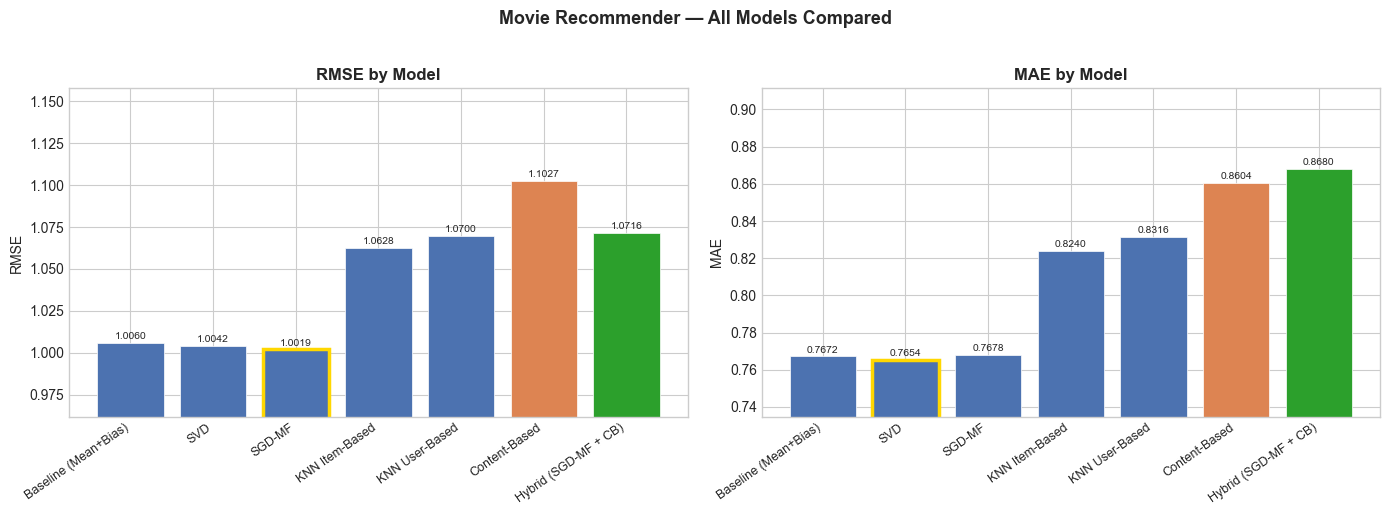

Chart saved to src/models/model_comparison.png


In [43]:
# ── Bar chart comparison ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n       = len(comparison)
palette = ['#4C72B0'] * 5 + ['#DD8452', '#2CA02C']  # CF=blue, CB=orange, Hybrid=green

for ax, metric in zip(axes, ['RMSE', 'MAE']):
    vals  = comparison[metric].values
    names = comparison.index.tolist()
    bars  = ax.bar(range(n), vals, color=palette, edgecolor='white', linewidth=0.5)
    ax.set_xticks(range(n))
    ax.set_xticklabels(names, rotation=35, ha='right', fontsize=9)
    ax.set_title(f'{metric} by Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(bottom=min(vals) * 0.96)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.001,
                f'{v:.4f}', ha='center', va='bottom', fontsize=7.5)
    best_idx = int(np.argmin(vals))
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(2.5)

plt.suptitle('Movie Recommender — All Models Compared', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(models_dir / 'model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('Chart saved to src/models/model_comparison.png')

## Recommendations Demo

We pick three users with very different activity levels and show their top-5 hybrid recommendations.

Notice how **α** (CF weight) changes:
- Light user → CF weight is low, CB drives the result (genre/tag matching)
- Power user → CF weight is high, collaborative signal dominates

In [44]:
def get_hybrid_recommendations(user_id, n=10, verbose=True):
    """Top-N hybrid recommendations — fully vectorised."""
    rated_ids    = set(train_df[train_df['userId'] == user_id]['movieId'])
    unrated_mask = ~np.isin(all_movie_ids, list(rated_ids))

    unrated_mids = all_movie_ids[unrated_mask]
    cf_midxs_un  = all_cf_midxs[unrated_mask]
    cb_midxs_un  = all_cb_midxs[unrated_mask]
    has_cb_un    = cb_midxs_un >= 0

    uidx    = user_id_map.get(user_id)
    profile = None
    try:
        profile = build_profile(train_groups.get_group(user_id))
    except KeyError:
        pass

    # CF batch
    cf_preds = np.full(len(unrated_mids), global_mean)
    if uidx is not None:
        cf_preds = sgd_model.predict_batch(
            np.full(len(unrated_mids), uidx), cf_midxs_un
        )

    # CB batch
    cb_preds = np.full(len(unrated_mids), cb_b)
    if profile is not None and has_cb_un.any():
        raw = np.asarray(
            movie_feature_matrix[cb_midxs_un[has_cb_un]].dot(profile)
        ).flatten()
        cb_preds[has_cb_un] = np.clip(cb_a * raw + cb_b, 0.5, 5.0)

    alpha  = get_alpha(user_id) if uidx is not None else 0.0
    scores = alpha * cf_preds + (1 - alpha) * cb_preds
    top_k  = np.argsort(scores)[::-1][:n]

    recs = []
    for i in top_k:
        mid = int(unrated_mids[i])
        row = movies[movies['movieId'] == mid]
        if len(row) == 0:
            continue
        row = row.iloc[0]
        recs.append({
            'title'        : row['title'],
            'genres'       : row['genres'],
            'hybrid_score' : round(float(scores[i]), 3),
            'cf_score'     : round(float(cf_preds[i]), 3),
            'cb_score'     : round(float(cb_preds[i]), 3),
            'avg_rating'   : round(float(row.get('avg_rating', 0)), 2),
        })

    df = pd.DataFrame(recs)
    if verbose:
        n_rated = len(rated_ids)
        a_val   = get_alpha(user_id) if uidx is not None else 0.0
        print(f'User {user_id}: {n_rated} rated movies | alpha(CF) = {a_val:.1f} | alpha(CB) = {1-a_val:.1f}')
        if len(df):
            print(df[['title', 'genres', 'hybrid_score', 'cf_score', 'cb_score']].to_string(index=False))
    return df


# ── Sample: light / median / heavy user ──────────────────────────────────
activity   = train_df.groupby('userId').size().sort_values()
light_uid  = activity.index[max(0, int(len(activity) * 0.10))]
median_uid = activity.index[int(len(activity) * 0.50)]
heavy_uid  = activity.index[-1]

for uid in [light_uid, median_uid, heavy_uid]:
    print(f'\n{"=" * 70}')
    get_hybrid_recommendations(uid, n=5, verbose=True)
print()


User 57509: 24 rated movies | alpha(CF) = 0.3 | alpha(CB) = 0.7
                                                    title                                                 genres  hybrid_score  cf_score  cb_score
                                         Inception (2010)        Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX         4.440     4.522     4.405
                             Kaho Naa... Pyaar Hai (2000) Action|Adventure|Comedy|Drama|Mystery|Romance|Thriller         4.396     3.935     4.594
Secret in Their Eyes, The (El secreto de sus ojos) (2009)                   Crime|Drama|Mystery|Romance|Thriller         4.391     4.466     4.358
                      City of God (Cidade de Deus) (2002)                  Action|Adventure|Crime|Drama|Thriller         4.347     4.641     4.221
                   Confessions of a Dangerous Mind (2002)                    Comedy|Crime|Drama|Romance|Thriller         4.346     4.180     4.417

User 44193: 68 rated movies | alpha(CF) = 0.6 | alph

In [45]:
# ── Save final results ────────────────────────────────────────────────────
hybrid_summary = {
    'model'           : 'Hybrid (SGD-MF + CB)',
    'eval_sample_size': EVAL_SAMPLE,
    'rmse'            : round(hybrid_rmse, 6),
    'mae'             : round(hybrid_mae,  6),
    'cf_best_rmse'    : round(float(cf_results.loc['SGD-MF', 'rmse']), 6),
    'cf_best_mae'     : round(float(cf_results.loc['SGD-MF', 'mae']),  6),
    'cb_rmse_scaled'  : round(cb_rmse_scaled, 6),
    'cb_mae_scaled'   : round(cb_mae_scaled,  6),
    'strategy'        : 'adaptive_alpha',
    'cb_calibration'  : {'a': round(cb_a, 6), 'b': round(cb_b, 6)},
    'alpha_thresholds': {'new_user': new_thresh, 'moderate': mod_thresh},
    'alpha_values'    : {'new': alpha_new, 'moderate': alpha_mod, 'power': alpha_power},
}

hybrid_path  = models_dir / 'hybrid_results.yaml'
compare_path = models_dir / 'all_models_comparison.csv'

with open(hybrid_path, 'w') as f:
    yaml.dump(hybrid_summary, f, default_flow_style=False, sort_keys=False)

comparison.round(6).to_csv(compare_path)

print('Results saved!')
print(f'  {hybrid_path}')
print(f'  {compare_path}')
print(f'\nFinal numbers:')
print(f'  Hybrid RMSE  : {hybrid_rmse:.4f}')
print(f'  Hybrid MAE   : {hybrid_mae:.4f}')
print(f'  Best CF RMSE : {cf_results["rmse"].min():.4f}  (SGD-MF)')

Results saved!
  c:\Users\ololi\StudioProjects\movie-recommender\src\models\hybrid_results.yaml
  c:\Users\ololi\StudioProjects\movie-recommender\src\models\all_models_comparison.csv

Final numbers:
  Hybrid RMSE  : 1.0716
  Hybrid MAE   : 0.8680
  Best CF RMSE : 1.0019  (SGD-MF)
